In [1]:
"""Base class for applications"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from deepcell_toolbox.utils import resize, tile_image, untile_image, untile_image_deprecated

class Application(object):
    """Application object that takes a model with weights and manages predictions

        Args:
            model (tf.model): Tensorflow model with weights loaded
            model_image_shape (tuple, optional): Shape of input expected by model.
                Defaults to `(128, 128, 1)`.
            dataset_metadata (optional): Any input, e.g. str or dict. Defaults to None.
            model_metadata (optional): Any input, e.g. str or dict. Defaults to None.
            model_mpp (float, optional): Microns per pixel resolution of training data.
                Defaults to 0.65.
            preprocessing_fn (function, optional): Preprocessing function to apply to data
                prior to prediction. Defaults to None.
            postprocessing_fn (function, optional): Postprocessing function to apply
                to data after prediction. Defaults to None.
                Must accept an input of a list of arrays and then return a single array.

        Raises:
            ValueError: `Preprocessing_fn` must be a callable function
            ValueError: `Postprocessing_fn` must be a callable function
    """

    def __init__(self,
                 model,
                 model_image_shape=(128, 128, 1),
                 model_mpp=0.65,
                 preprocessing_fn=None,
                 postprocessing_fn=None,
                 dataset_metadata=None,
                 model_metadata=None):

        print('TRACKING: initiating JUPYTER application class')                         # tracking (Cole)
        
        self.model = model

        self.model_image_shape = model_image_shape
        # Require dimension 1 larger than model_input_shape due to addition of batch dimension
        self.required_rank = len(self.model_image_shape) + 1

        self.required_channels = self.model_image_shape[-1]

        self.model_mpp = model_mpp
        self.preprocessing_fn = preprocessing_fn
        self.postprocessing_fn = postprocessing_fn
        self.dataset_metadata = dataset_metadata
        self.model_metadata = model_metadata

        # Test that pre and post processing functions are callable
        if self.preprocessing_fn is not None and not callable(self.preprocessing_fn):
            raise ValueError('Preprocessing_fn must be a callable function.')
        if self.postprocessing_fn is not None and not callable(self.postprocessing_fn):
            raise ValueError('Postprocessing_fn must be a callable function.')

    def predict(self, x):

        print('TRACKING: application.py --> predict(...)')                                              # Cole's edits - tracking

        raise NotImplementedError

    def _resize_input(self, image, image_mpp):
        """Checks if there is a difference between image and model resolution
        and resizes if they are different. Otherwise returns the unmodified image.

        Args:
            image (array): Input image to resize
            image_mpp (float): Microns per pixel for the input image

        Returns:
            array: Input image resized if necessary to match `model_mpp`
        """

        # Don't scale the image if mpp is the same or not defined
        if image_mpp not in {None, self.model_mpp}:
            scale_factor = image_mpp / self.model_mpp
            new_shape = (int(image.shape[1] * scale_factor),
                         int(image.shape[2] * scale_factor))
            image = resize(image, new_shape, data_format='channels_last')

        return image

    def _preprocess(self, image, **kwargs):
        """Preprocess image if `preprocessing_fn` is defined.
        Otherwise return unmodified image
        """
        if self.preprocessing_fn is not None:
            image = self.preprocessing_fn(image, **kwargs)

        return image

    def _tile_input(self, image):
        """Tile the input image to match shape expected by model
        using the deepcell_toolbox function.
        Currently only supports 4d images and otherwise raises an error

        Args:
            image (array): Input image to tile

        Raises:
            ValueError: Input images must have only 4 dimensions

        Returns:
            (array, dict): Tuple of tiled image and dictionary of tiling specs
        """

        if len(image.shape) != 4:
            raise ValueError('deepcell_toolbox.tile_image only supports 4d images.'
                             'Image submitted for predict has {} dimensions'.format(
                                 len(image.shape)))

        # Check difference between input and model image size
        x_diff = image.shape[1] - self.model_image_shape[0]
        y_diff = image.shape[2] - self.model_image_shape[1]

        # Check if the input is smaller than model image size
        if x_diff < 0 or y_diff < 0:
            # Calculate padding
            x_diff, y_diff = abs(x_diff), abs(y_diff)
            x_pad = (x_diff // 2, x_diff // 2 + 1) if x_diff % 2 else (x_diff // 2, x_diff // 2)
            y_pad = (y_diff // 2, y_diff // 2 + 1) if y_diff % 2 else (y_diff // 2, y_diff // 2)

            tiles = np.pad(image, [(0, 0), x_pad, y_pad, (0, 0)], 'reflect')
            tiles_info = {'padding': True,
                          'x_pad': x_pad,
                          'y_pad': y_pad}
        # Otherwise tile images larger than model size
        else:
            # Tile images, needs 4d
            tiles, tiles_info = tile_image(image, model_input_shape=self.model_image_shape)

        return tiles, tiles_info

    def _postprocess(self, image, **kwargs):
        """Applies postprocessing function to image if one has been defined.
        Otherwise returns unmodified image.

        Args:
            image (array or list): Input to postprocessing function
                either an array or list of arrays

        Returns:
            array: labeled image
        """

        if self.postprocessing_fn is not None:
            image = self.postprocessing_fn(image, **kwargs)

            # Restore channel dimension if not already there
            if len(image.shape) == self.required_rank - 1:
                image = np.expand_dims(image, axis=-1)

        elif isinstance(image, list) and len(image) == 1:
            image = image[0]

        return image

    def _untile_output(self, output_tiles, tiles_info):
        """Untiles either a single array or a list of arrays
        according to a dictionary of tiling specs

        Args:
            output_tiles (array or list): Array or list of arrays
            tiles_info (dict): Dictionary of tiling specs output by tiling function

        Returns:
            array or list: Array or list according to input with untiled images
        """

        print('TRACKING: application.py --> untile_output')                   # Cole's edits - tracking

        # If padding was used, remove padding
        if tiles_info.get('padding', False):
            def _process(im, tiles_info):
                x_pad, y_pad = tiles_info['x_pad'], tiles_info['y_pad']
                out = im[:, x_pad[0]:-x_pad[1], y_pad[0]:-y_pad[1], :]
                return out
        # Otherwise untile
        else:
            def _process(im, tiles_info):
                #out = untile_image_old(im, tiles_info, model_input_shape=self.model_image_shape) #toolbox untile
                
                out = untile_image_new(im, tiles_info)      # Dave's untile

        
#def untile_image(tiles, tiles_info, model_input_shape=(512, 512)): # old call
#def _untile_image(self, tiles, tiles_info, stride_fraction=0.5) # new call
                
                return out

        if isinstance(output_tiles, list):
            output_images = [_process(o, tiles_info) for o in output_tiles]
        else:
            output_images = _process(output_tiles, tiles_info)

        return output_images

    def _resize_output(self, image, original_shape):
        """Rescales input if the shape does not match the original shape
        excluding the batch and channel dimensions

        Args:
            image (array): Image to be rescaled to original shape
            original_shape (tuple): Shape of the original input image

        Returns:
            array: Rescaled image
        """

        # Compare x,y based on rank of image
        if len(image.shape) == 4:
            same = image.shape[1:-1] == original_shape[1:-1]
        elif len(image.shape) == 3:
            same = image.shape[1:] == original_shape[1:-1]
        else:
            same = image.shape == original_shape[1:-1]

        # Resize if same is false
        if not same:
            # Resize function only takes the x,y dimensions for shape
            new_shape = original_shape[1:-1]
            image = resize(image, new_shape,
                           data_format='channels_last',
                           labeled_image=True)
        return image

    def _run_model(self,
                   image,
                   batch_size=4,
                   preprocess_kwargs={}):
        """Run the model to generate output probabilities on the data.

        Args:
            image (np.array): Input image with shape `[batch, x, y, channel]`
            batch_size (int, optional): Number of images to predict on per batch. Defaults to 4.
            preprocess_kwargs (dict, optional): Kwargs to pass to preprocessing function.
                Defaults to {}.

        Returns:
            np.array: Model outputs
        """

        # Preprocess image if function is defined
        image = self._preprocess(image, **preprocess_kwargs)

        # Tile images, raises error if the image is not 4d
        tiles, tiles_info = self._tile_input(image)

        # Run images through model
        output_tiles = self.model.predict(tiles, batch_size=batch_size)

        # Untile images                                                                                                                                                            272,1         54%
        output_images = self._untile_output(output_tiles, tiles_info)    

        
        return output_images

    def _predict_segmentation(self,
                              image,
                              batch_size=4,
                              image_mpp=None,
                              preprocess_kwargs={},
                              postprocess_kwargs={}):
        """Generates a labeled image of the input running prediction with
        appropriate pre and post processing functions.

        Input images are required to have 4 dimensions `[batch, x, y, channel]`. Additional
        empty dimensions can be added using `np.expand_dims`

        Args:
            image (np.array): Input image with shape `[batch, x, y, channel]`
            batch_size (int, optional): Number of images to predict on per batch. Defaults to 4.
            image_mpp (float, optional): Microns per pixel for the input image. Defaults to None.
            preprocess_kwargs (dict, optional): Kwargs to pass to preprocessing function.
                Defaults to {}.
            postprocess_kwargs (dict, optional): Kwargs to pass to postprocessing function.
                Defaults to {}.

        Raises:
            ValueError: Input data must match required rank of the application, calculated as
                one dimension more (batch dimension) than expected by the model

            ValueError: Input data must match required number of channels of application

        Returns:
            np.array: Labeled image
        """

        print('TRACKING: application.py --> _predict_segmentation(...)')                                        # Cole's edits - tracking

        # Check input size of image
        if len(image.shape) != self.required_rank:
            raise ValueError('Input data must have {} dimensions. '
                             'Input data only has {} dimensions'.format(
                                                                                                                   self.required_rank, len(image.shape)))

        if image.shape[-1] != self.required_channels:
            raise ValueError('Input data must have {} channels. '
                             'Input data only has {} channels'.format(
                                 self.required_channels, image.shape[-1]))

        # Resize image, returns unmodified if appropriate
        resized_image = self._resize_input(image, image_mpp)

        # Generate model outputs
        output_images = self._run_model(image=resized_image, batch_size=batch_size,
                                        preprocess_kwargs=preprocess_kwargs)

        # Postprocess predictions to create label image
        label_image = self._postprocess(output_images, **postprocess_kwargs)

        # Resize label_image back to original resolution if necessary
        label_image = self._resize_output(label_image, image.shape)

        return label_image


    
    #new untile code
    def _spline_window(self, window_size, stride_fraction=0.5, power=2, half=0):
        import scipy.signal
        """
        Squared spline (power=2) window function:
        https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
        """
        reduced_window_size = int(window_size * 2* (1 - stride_fraction))
        intersection = int(reduced_window_size/4)
        wind_outer = (abs(2*(scipy.signal.triang(reduced_window_size))) ** power)/2
        wind_outer[intersection:-intersection] = 0
        wind_inner = 1 - (abs(2*(scipy.signal.triang(reduced_window_size) - 1)) ** power)/2
        wind_inner[:intersection] = 0
        wind_inner[-intersection:] = 0
        wind = wind_inner + wind_outer
        wind = wind / np.amax(wind)

        new_wind = np.zeros((window_size,))
        new_wind[0:reduced_window_size // 2] = wind[0:reduced_window_size // 2]
        new_wind[-reduced_window_size // 2:] = wind[-reduced_window_size // 2:]
        new_wind[reduced_window_size // 2:-reduced_window_size // 2] = 1

        if half == 0:
            return new_wind
        elif half == -1:
            new_wind[0:window_size // 2] = 1
        elif half == 1:
            new_wind[window_size // 2:] = 1
        return new_wind

    def _window_2D(self, window_size, stride_fraction=0.5, power=2, edge_0=None, edge_1=None):
        """
        Make a 1D window function, then infer and return a 2D window function.
        Done with an augmentation, and self multiplication with its transpose.
        Could be generalized to more dimensions.
        """
        if edge_0 is None:
            half_0 = 0
        elif edge_0 == -1:
            half_0 = -1
        elif edge_0 == 1:
            half_0 = 1
        wind_0 = self._spline_window(window_size, power=power, stride_fraction=stride_fraction, half=half_0)
        if edge_1 is None:
            half_1 = 0
        elif edge_1 == -1:
            half_1 = -1
        elif edge_1 == 1:
            half_1 = 1
        wind_1 = self._spline_window(window_size, power=power, stride_fraction=stride_fraction, half=half_1)
        wind_0 = np.expand_dims(np.expand_dims(wind_0, -1), -1)
        wind_1 = np.expand_dims(np.expand_dims(wind_1, -1), -1)
        wind = wind_0 * wind_1.transpose(1, 0, 2)
        return wind

    def _untile_image(self, tiles, tiles_info, stride_fraction=0.5):
        
        print("TRACKING: Dave's untile")                   
        
        _axis = 1
        image_shape = tiles_info['image_shape']
        batches = tiles_info['batches']
        x_starts = tiles_info['x_starts']
        x_ends = tiles_info['x_ends']
        y_starts = tiles_info['y_starts']
        y_ends = tiles_info['y_ends']
        stride_x = tiles_info['stride_x']
        stride_y = tiles_info['stride_y']
        
        tile_size_x = self.model_image_shape[0]
        tile_size_y = self.model_image_shape[1]

        #print('tiles type is: ', type(tiles))
        #print('tiles shape is: ', tiles.shape[-1])
        
        image_shape = [image_shape[0], image_shape[1], image_shape[2], tiles.shape[-1]]
        image = np.zeros(image_shape, dtype = K.floatx())
        n_tiles = tiles.shape[0]

        for tile, batch, x_start, x_end, y_start, y_end in zip(tiles, batches, x_starts, x_ends, y_starts, y_ends):
            tile_x_start = 0
            tile_x_end = tile_size_x
            tile_y_start = 0
            tile_y_end = tile_size_y

            if x_start == 0:
                edge_0 = -1
            elif x_end == image_shape[1]:
                edge_0 = 1
            else:
                edge_0=None
            if y_start == 0:
                edge_1 = -1
            elif y_end == image_shape[2]:
                edge_1 = 1
            else:
                edge_1=None

            window = self._window_2D(128, stride_fraction=stride_fraction, edge_0=edge_0, edge_1=edge_1)
            image[batch, x_start:x_end, y_start:y_end, :] += tile * window
            return image








In [2]:
"""Cytoplasmic segmentation application"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from tensorflow.python.keras.utils.data_utils import get_file

from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell_toolbox.processing import phase_preprocess

#from deepcell.applications import Application
from deepcell.model_zoo import PanopticNet


WEIGHTS_PATH = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
                'model-weights/general_cyto_named.h5')


class CytoplasmSegmentation(Application):
    """Loads a `deepcell.model_zoo.PanopticNet` model for cytoplasm segmentation
    with pretrained weights.
    The `predict` method handles prep and post processing steps to return a labeled image.

    Example:

    .. nbinput:: ipython3

        from skimage.io import imread
        from deepcell.applications import CytoplasmSegmentation

        im = imread('HeLa_cytoplasm.png')
        im.shape

    .. nboutput::

        (1080, 1280)

    .. nbinput:: ipython3

                                                                            
        app = CytoplasmSegmentation(use_pretrained_weights=True)
        labeled_image = app.predict(image)

    .. nboutput::

    Args:
        use_pretrained_weights (bool, optional): Loads pretrained weights. Defaults to True.
        model_image_shape (tuple, optional): Shape of input data expected by model.
            Defaults to `(128, 128, 1)`
    """

    #: Metadata for the dataset used to train the model
    dataset_metadata = {
        'name': 'general_cyto',
        'other': 'Pooled phase and fluorescent cytoplasm data - computationally curated'
    }

    #: Metadata for the model and training process
    model_metadata = {
        'batch_size': 2,
        'lr': 1e-4,
        'lr_decay': 0.95,
        'training_seed': 0,
        'n_epochs': 8,
        'training_steps_per_epoch': 7899 // 2,
        'validation_steps_per_epoch': 1973 // 2
    }

    def __init__(self,
                 use_pretrained_weights=True,
                 model_image_shape=(128, 128, 1)):

        print('TRACKING: applications/cytoplasm_segmentation.py --> __init__ EDITED')                          # tracking (Cole)

        model = PanopticNet('resnet50',
                            input_shape=model_image_shape,
                            norm_method='whole_image',
                            num_semantic_heads=2,
                            num_semantic_classes=[1, 1],
                            location=True,
                            include_top=True,
                            lite=True,
                            interpolation='bilinear')

        if use_pretrained_weights:
            weights_path = get_file(
                os.path.basename(WEIGHTS_PATH),
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='104a7d7884c80c37d2bce6d1c3a17c7a'
            )


            model.load_weights(weights_path, by_name=True)
        else:
            weights_path = None

        super(CytoplasmSegmentation, self).__init__(model,
                                                    model_image_shape=model_image_shape,
                                                    model_mpp=0.65,
                                                    preprocessing_fn=phase_preprocess,
                                                    postprocessing_fn=deep_watershed,
                                                    dataset_metadata=self.dataset_metadata,
                                                    model_metadata=self.model_metadata)

    def predict(self,
                image,
                batch_size=4,
                image_mpp=None,
                preprocess_kwargs={},
                postprocess_kwargs={}):
        """Generates a labeled image of the input running prediction with
        appropriate pre and post processing functions.

        Input images are required to have 4 dimensions `[batch, x, y, channel]`. Additional
        empty dimensions can be added using `np.expand_dims`

        Args:
            image (np.array): Input image with shape `[batch, x, y, channel]`
            batch_size (int, optional): Number of images to predict on per batch. Defaults to 4.
            image_mpp (float, optional): Microns per pixel for the input image. Defaults to None.
            preprocess_kwargs (dict, optional): Kwargs to pass to preprocessing function.
                Defaults to {}.
            postprocess_kwargs (dict, optional): Kwargs to pass to postprocessing function.
                Defaults to {}.

        Raises:
            ValueError: Input data must match required rank of the application, calculated as
                one dimension more (batch dimension) than expected by the model

            ValueError: Input data must match required number of channels of application

        Returns:
            np.array: Labeled image
        """

        print('TRACKING: applications/cytoplasm_segmentation.py --> predict')                       # tracking (Cole)

        return self._predict_segmentation(image,
                                          batch_size=batch_size,
                                          image_mpp=image_mpp,
                                          preprocess_kwargs=preprocess_kwargs,
                                          postprocess_kwargs=postprocess_kwargs)

  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [3]:
# old untile code ################
def untile_image_old(tiles, tiles_info, model_input_shape=(512, 512)):
    """Untile a set of tiled images back to the original model shape.
    Args:
        tiles (numpy.array): The tiled images image to untile.
        tiles_info (dict): Details of how the image was tiled (from tile_image).
        model_input_shape (tuple): The input size of the model.
    Returns:
        numpy.array: The untiled image.
    """
    
    print('TRACKING: untile_image_old')
    
    _axis = 1
    image_shape = tiles_info['image_shape']
    batches = tiles_info['batches']
    x_starts = tiles_info['x_starts']
    x_ends = tiles_info['x_ends']
    y_starts = tiles_info['y_starts']
    y_ends = tiles_info['y_ends']
    stride_x = tiles_info['stride_x']
    stride_y = tiles_info['stride_y']

    tile_size_x = model_input_shape[0]
    tile_size_y = model_input_shape[1]

    image_shape = tuple(list(image_shape[0:3]) + [tiles.shape[-1]])
    image = np.zeros(image_shape, dtype=tiles.dtype)

    zipped = zip(tiles, batches, x_starts, x_ends, y_starts, y_ends)
    for tile, batch, x_start, x_end, y_start, y_end in zipped:
        tile_x_start = 0
        tile_x_end = tile_size_x
        tile_y_start = 0
        tile_y_end = tile_size_y

        if x_start != 0:
            x_start += (tile_size_x - stride_x) // 2
            tile_x_start += (tile_size_x - stride_x) // 2
        if x_end != image_shape[_axis]:
            x_end -= (tile_size_x - stride_x) // 2
            tile_x_end -= (tile_size_x - stride_x) // 2
        if y_start != 0:
            y_start += (tile_size_y - stride_y) // 2
            tile_y_start += (tile_size_y - stride_y) // 2
        if y_end != image_shape[_axis + 1]:
            y_end -= (tile_size_y - stride_y) // 2
            tile_y_end -= (tile_size_y - stride_y) // 2

        x_start = np.int(x_start)
        x_end = np.int(x_end)
        y_start = np.int(y_start)
        y_end = np.int(y_end)

        tile_x_start = np.int(tile_x_start)
        tile_x_end = np.int(tile_x_end)
        tile_y_start = np.int(tile_y_start)
        tile_y_end = np.int(tile_y_end)

        t = tile[tile_x_start:tile_x_end, tile_y_start:tile_y_end]
        image[batch, x_start:x_end, y_start:y_end] = t

    return image

In [ ]:
# new untile code
def spline_window(window_size, stride_fraction=0.5, power=2, half=0):
    import scipy.signal
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    reduced_window_size = int(window_size * 2 * (1 - stride_fraction))
    intersection = int(reduced_window_size / 4)
    wind_outer = (abs(2 * (scipy.signal.triang(reduced_window_size))) ** power) / 2
    wind_outer[intersection:-intersection] = 0
    wind_inner = 1 - (abs(2 * (scipy.signal.triang(reduced_window_size) - 1)) ** power) / 2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0
    wind = wind_inner + wind_outer

    try:
        wind = wind / np.amax(wind)
    except ValueError:  # raised if `wind` is empty.
        raise ValueError('Stride fraction of 1 is invalid')   # Stride fraction must be 0 < x < 1

    new_wind = np.zeros((window_size,))
    new_wind[0:reduced_window_size // 2] = wind[0:reduced_window_size // 2]
    new_wind[-reduced_window_size // 2:] = wind[-reduced_window_size // 2:]
    new_wind[reduced_window_size // 2:-reduced_window_size // 2] = 1

    if half == 0:
        return new_wind
    elif half == -1:
        new_wind[0:window_size // 2] = 1
    elif half == 1:
        new_wind[window_size // 2:] = 1
        
    return new_wind


def window_2D(window_size, stride_fraction=0.5, power=2, edge_0=None, edge_1=None):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    if edge_0 is None:
        half_0 = 0
    elif edge_0 == -1:
        half_0 = -1
    elif edge_0 == 1:
        half_0 = 1
    wind_0 = spline_window(window_size, power=power, stride_fraction=stride_fraction, half=half_0)
    if edge_1 is None:
        half_1 = 0
    elif edge_1 == -1:
        half_1 = -1
    elif edge_1 == 1:
        half_1 = 1
    wind_1 = spline_window(window_size, power=power, stride_fraction=stride_fraction, half=half_1)
    wind_0 = np.expand_dims(np.expand_dims(wind_0, -1), -1)
    wind_1 = np.expand_dims(np.expand_dims(wind_1, -1), -1)
    wind = wind_0 * wind_1.transpose(1, 0, 2)
    
    return wind


def untile_image(tiles, tiles_info, model_input_shape=(512, 512), stride_fraction=0.5):

    print("12345")
    
    if not (0 < stride_fraction < 1):
        raise ValueError('stride_fraction must be between 0 and 1 (not inclusive)')

    _axis = 1
    image_shape = tiles_info['image_shape']    # image_shape is 
    batches = tiles_info['batches']
    x_starts = tiles_info['x_starts']
    x_ends = tiles_info['x_ends']
    y_starts = tiles_info['y_starts']
    y_ends = tiles_info['y_ends']
    stride_x = tiles_info['stride_x']
    stride_y = tiles_info['stride_y']

    tile_size_x = model_input_shape[0]
    tile_size_y = model_input_shape[1]

    image_shape = [image_shape[0], image_shape[1], image_shape[2], tiles.shape[-1]]
    image = np.zeros(image_shape, dtype = K.floatx())
    #image = np.zeros(image_shape, dtype=tiles.dtype)
    n_tiles = tiles.shape[0]

    for tile, batch, x_start, x_end, y_start, y_end in zip(
            tiles, batches, x_starts, x_ends, y_starts, y_ends):
        tile_x_start = 0
        tile_x_end = tile_size_x
        tile_y_start = 0
        tile_y_end = tile_size_y

        if x_start == 0:
            edge_0 = -1
        elif x_end == image_shape[1]:
            edge_0 = 1
        else:
            edge_0 = None
        if y_start == 0:
            edge_1 = -1
        elif y_end == image_shape[2]:
            edge_1 = 1
        else:
            edge_1 = None

        win_dim = tile.shape[0]
        # window = window_2D(128, stride_fraction=stride_fraction, edge_0=edge_0, edge_1=edge_1)
        window = window_2D(win_dim, stride_fraction=stride_fraction, edge_0=edge_0, edge_1=edge_1)
        print("")
        #window = window.astype(tiles.dtype)
        image[batch, x_start:x_end, y_start:y_end, :] += tile * window
        
    return image



In [5]:

# cytoplasm_segmentation.py (application - child)
#     - __init__ function creates model. "model = PanopticNet(...)
#     - predict(...) calls self._predict_segmentation(...), the parent application class function

# Application.py (application - parent class)
#     - application object *takes* a model with weights and manages predictions
#     - _predict_segmentation CALLS self._resize_input(), self._run_model(), self._postprocess(), and self._resize_output()
#          - self._run_model() CALLS self._tile_input(), self.model.predict, and self._untile_output()
#               - _tile_input() CALLS the toolbox.utils --> tile_image() 
#               - _untile_output() CALL the toolbox.tils --> untile_image()



# so what I need to do is figure out what the inputs and outputs of tile_image() and untile_image() are


In [6]:
import os
import numpy as np

import tensorflow as tf

from tensorflow.python.keras import backend as K

from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from deepcell.applications import CytoplasmSegmentation
from deepcell.datasets.cytoplasm import hela_s3

In [7]:
((X_train, y_train),(X_test, y_test)) = hela_s3.load_data()
im = X_test
im.shape

632602624/632595468 [==============================] - 14s 0us/step


(331, 512, 512, 1)

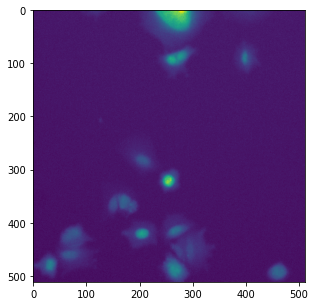

In [194]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 326
ax.imshow(im[i, ..., 0])
plt.show()

In [195]:
app = CytoplasmSegmentation()
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.65 microns per pixel


In [203]:
img=im.astype('uint16')

labeled_im = app.predict(img, image_mpp=0.65)      
labeled_im.shape

(331, 512, 512, 1)

uint16


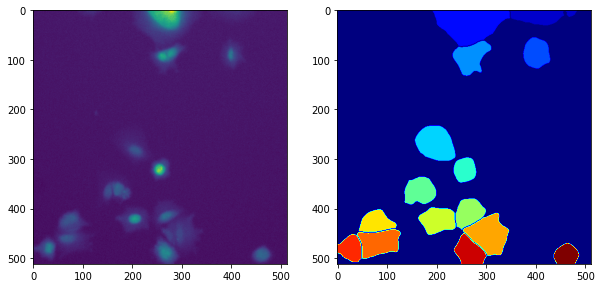

In [204]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(im[i, ..., 0])
ax[1].imshow(labeled_im[i, ..., 0], cmap='jet')
plt.show()

In [12]:
labeled_im = app.predict(im, image_mpp=0.65)       # this is what I need to sub-in.
labeled_im.shape

(331, 512, 512, 1)

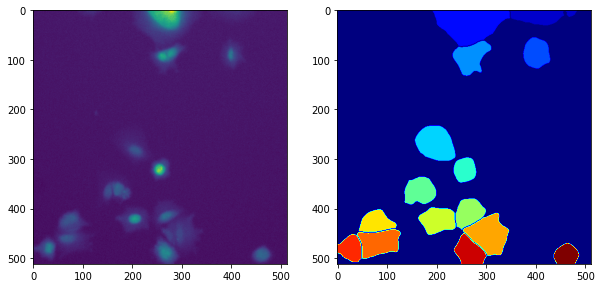

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(im[i, ..., 0])
ax[1].imshow(labeled_im[i, ..., 0], cmap='jet')
plt.show()

In [94]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from itertools import product

import numpy as np
from skimage.measure import label

#import pytest

from deepcell_toolbox import utils

def test_untile_image():
    shapes = [
        (4, 21, 21, 1),
        (4, 21, 31, 2),
        (4, 31, 21, 3),
    ]
    model_input_shapes = [(3, 3), (5, 5), (7, 7), (12, 12), (1028, 1028)]
    
    stride_ratios = [0.25, 0.33, 0.5, 0.66, 0.75, 0.8]         # removed stride ratio of 1 because untile does not work with it

    dtypes = ['int32', 'float32', 'uint16', 'float16']

    #model_input_shapes = [(1,1)]
    #stride_ratios = [1]
    #dtypes = ['int32']
    
    prod = product(shapes, model_input_shapes, stride_ratios, dtypes)

    for shape, input_shape, stride_ratio, dtype in prod:
                
        big_image = (np.random.random(shape) * 100).astype(dtype)
        tiles, tiles_info = utils.tile_image(
            big_image, input_shape,
            stride_ratio=stride_ratio)

        untiled_image = untile_image_new(
            tiles=tiles, tiles_info=tiles_info,
            model_input_shape=input_shape, stride_fraction=stride_ratio)
        
        assert untiled_image.dtype == dtype
        assert untiled_image.shape == shape
 
        print("Diff is: ", untiled_image-big_image, 'shape is: ', shape, ', input_shape is: ',
              input_shape, ', stride_ratio is: ',
              stride_ratio, ', dtype is: ', dtype)

        #np.testing.assert_equal(untiled_image, big_image)        # this (new) untile function does not return an equivalent array, so this assertion is not relevant

In [95]:
test_untile_image()

Diff is:  [[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   

Diff is:  [[[[ 0.        ]
   [ 8.447563  ]
   [20.34729   ]
   ...
   [ 0.9450431 ]
   [ 4.300329  ]
   [ 0.        ]]

  [[ 7.6185913 ]
   [22.462952  ]
   [15.076412  ]
   ...
   [ 6.898304  ]
   [18.556808  ]
   [ 6.9407463 ]]

  [[24.89856   ]
   [44.933105  ]
   [44.210632  ]
   ...
   [ 9.193407  ]
   [19.451462  ]
   [20.665375  ]]

  ...

  [[ 8.822802  ]
   [ 0.77044547]
   [17.97768   ]
   ...
   [57.75435   ]
   [ 3.45681   ]
   [13.6996765 ]]

  [[13.768211  ]
   [27.268158  ]
   [25.277771  ]
   ...
   [10.346058  ]
   [19.586723  ]
   [ 2.332983  ]]

  [[ 0.        ]
   [ 4.9798927 ]
   [ 1.24722   ]
   ...
   [17.470066  ]
   [10.10202   ]
   [ 0.        ]]]


 [[[ 0.        ]
   [12.7890625 ]
   [17.453995  ]
   ...
   [18.26109   ]
   [ 2.9062386 ]
   [ 0.        ]]

  [[ 4.99815   ]
   [17.620937  ]
   [12.733488  ]
   ...
   [ 5.081811  ]
   [ 6.5989304 ]
   [ 8.231041  ]]

  [[ 4.4494944 ]
   [30.207413  ]
   [33.161762  ]
   ...
   [54.945343  ]
   [30.189201  ]
 

Diff is:  [[[[  0.    ]
   [  0.    ]
   [-22.08  ]
   ...
   [-32.06  ]
   [  0.    ]
   [  0.    ]]

  [[  0.    ]
   [  0.    ]
   [-16.8   ]
   ...
   [-20.1   ]
   [  0.    ]
   [  0.    ]]

  [[-18.75  ]
   [-12.18  ]
   [ -5.992 ]
   ...
   [ -9.31  ]
   [ -3.367 ]
   [-35.16  ]]

  ...

  [[-43.78  ]
   [-30.16  ]
   [-26.12  ]
   ...
   [-39.4   ]
   [-25.89  ]
   [-43.22  ]]

  [[  0.    ]
   [  0.    ]
   [-15.46  ]
   ...
   [-36.8   ]
   [  0.    ]
   [  0.    ]]

  [[  0.    ]
   [  0.    ]
   [-33.34  ]
   ...
   [ -9.14  ]
   [  0.    ]
   [  0.    ]]]


 [[[  0.    ]
   [  0.    ]
   [-12.09  ]
   ...
   [-33.34  ]
   [  0.    ]
   [  0.    ]]

  [[  0.    ]
   [  0.    ]
   [-39.    ]
   ...
   [-18.28  ]
   [  0.    ]
   [  0.    ]]

  [[-32.28  ]
   [-34.1   ]
   [-72.44  ]
   ...
   [-49.38  ]
   [-31.42  ]
   [-26.95  ]]

  ...

  [[-28.4   ]
   [-10.15  ]
   [-69.7   ]
   ...
   [ -0.4417]
   [-38.06  ]
   [-24.5   ]]

  [[  0.    ]
   [  0.    ]
   [-26.1   ]
  

Diff is:  [[[[  0.   ]
   [  0.   ]
   [ 25.05 ]
   ...
   [ 13.28 ]
   [  0.   ]
   [  0.   ]]

  [[  0.   ]
   [  0.   ]
   [  6.992]
   ...
   [ 69.2  ]
   [  0.   ]
   [  0.   ]]

  [[ 67.   ]
   [ 15.7  ]
   [ 13.055]
   ...
   [188.6  ]
   [  1.612]
   [ 43.75 ]]

  ...

  [[ 37.7  ]
   [ 38.03 ]
   [ 67.3  ]
   ...
   [ 55.3  ]
   [ 63.   ]
   [ 65.56 ]]

  [[  0.   ]
   [  0.   ]
   [ 35.3  ]
   ...
   [  2.086]
   [  0.   ]
   [  0.   ]]

  [[  0.   ]
   [  0.   ]
   [ 84.94 ]
   ...
   [ 15.12 ]
   [  0.   ]
   [  0.   ]]]


 [[[  0.   ]
   [  0.   ]
   [  8.52 ]
   ...
   [  5.6  ]
   [  0.   ]
   [  0.   ]]

  [[  0.   ]
   [  0.   ]
   [ 75.8  ]
   ...
   [ 43.03 ]
   [  0.   ]
   [  0.   ]]

  [[ 88.75 ]
   [ 68.9  ]
   [253.8  ]
   ...
   [202.5  ]
   [ 69.4  ]
   [ 72.5  ]]

  ...

  [[ 69.9  ]
   [ 37.16 ]
   [226.   ]
   ...
   [145.1  ]
   [ 55.03 ]
   [  9.75 ]]

  [[  0.   ]
   [  0.   ]
   [ 70.75 ]
   ...
   [ 84.4  ]
   [  0.   ]
   [  0.   ]]

  [[  0.   ]
   [

Diff is:  [[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.

Diff is:  [[[[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [6.5938e+00]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [9.0000e+00]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [3.1250e-02]
   ...
   [9.0000e+00]
   [0.0000e+00]
   [0.0000e+00]]

  ...

  [[1.8281e+00]
   [7.6875e+00]
   [3.7500e+00]
   ...
   [1.0375e+01]
   [3.2500e+00]
   [3.6094e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [1.0562e+01]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [3.4062e+00]
   [0.0000e+00]
   [0.0000e+00]]]


 [[[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [7.1250e+00]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [6.7188e+00]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [3.9062e-03]
   ...
   [3.4688e+00]
   [0.0000e+00]
   [0.0000e+00]]

  ...

  [[1.0875e+01]
   [7.7812e+0

Diff is:  [[[[0.0000e+00]
   [0.0000e+00]
   [2.7812e+00]
   ...
   [5.6875e+00]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [1.4531e+00]
   ...
   [3.8125e+00]
   [0.0000e+00]
   [0.0000e+00]]

  [[1.4844e+00]
   [3.7500e+00]
   [9.7500e+00]
   ...
   [3.0312e+00]
   [3.9375e+00]
   [3.0078e-01]]

  ...

  [[3.4688e+00]
   [4.3125e+00]
   [4.3750e+00]
   ...
   [1.8125e+00]
   [3.8750e+00]
   [5.1875e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [1.4375e+00]
   ...
   [2.2812e+00]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [3.4375e+00]
   ...
   [1.8438e+00]
   [0.0000e+00]
   [0.0000e+00]]]


 [[[0.0000e+00]
   [0.0000e+00]
   [3.6562e+00]
   ...
   [2.6562e+00]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [2.4062e+00]
   ...
   [1.3125e+00]
   [0.0000e+00]
   [0.0000e+00]]

  [[3.2188e+00]
   [1.2344e+00]
   [1.1438e+01]
   ...
   [5.7812e+00]
   [2.1562e+00]
   [1.7656e+00]]

  ...

  [[5.6250e+00]
   [2.3438e+0

   [0]]]] shape is:  (4, 21, 21, 1) , input_shape is:  (5, 5) , stride_ratio is:  0.66 , dtype is:  uint16
Diff is:  [[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [

Diff is:  [[[[0.        ]
   [0.        ]
   [1.8713531 ]
   ...
   [1.7129135 ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.8729744 ]
   ...
   [0.20935345]
   [0.        ]
   [0.        ]]

  [[0.42481613]
   [0.68787   ]
   [0.09493685]
   ...
   [2.0110664 ]
   [1.4693832 ]
   [2.017456  ]]

  ...

  [[0.36559105]
   [1.5731812 ]
   [3.2496185 ]
   ...
   [1.1211052 ]
   [2.0344696 ]
   [1.0179176 ]]

  [[0.        ]
   [0.        ]
   [0.46535683]
   ...
   [1.3953323 ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.90192413]
   ...
   [0.33479118]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [1.4714432 ]
   ...
   [0.08876276]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [1.3131561 ]
   ...
   [0.704834  ]
   [0.        ]
   [0.        ]]

  [[1.605957  ]
   [1.6071854 ]
   [0.296731  ]
   ...
   [2.8115997 ]
   [0.79877853]
   [1.4219666 ]]

  ...

  [[0.7388191 ]
   [0.4039516

Diff is:  [[[[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 7.7627525 ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 0.93759394]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [10.213577  ]
   [ 0.        ]
   [ 0.        ]]

  ...

  [[ 7.7005653 ]
   [ 9.076805  ]
   [ 6.1641197 ]
   ...
   [ 1.1469736 ]
   [10.679787  ]
   [ 7.7017975 ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 8.157776  ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 7.2502747 ]
   [ 0.        ]
   [ 0.        ]]]


 [[[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 5.957039  ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [10.148483  ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [11.519196  ]
   [ 0.        ]
 

Diff is:  [[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   

Diff is:  [[[[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [3.4062e+01]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [2.2797e+01]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [1.9125e+01]
   [0.0000e+00]
   [0.0000e+00]]

  ...

  [[1.2695e+01]
   [3.1680e+00]
   [8.7688e+01]
   ...
   [2.9925e+02]
   [5.3938e+01]
   [5.8000e+01]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [8.3188e+01]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [8.6375e+01]
   [0.0000e+00]
   [0.0000e+00]]]


 [[[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [8.0625e+01]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [3.7406e+01]
   [0.0000e+00]
   [0.0000e+00]]

  [[0.0000e+00]
   [0.0000e+00]
   [0.0000e+00]
   ...
   [2.0375e+01]
   [0.0000e+00]
   [0.0000e+00]]

  ...

  [[2.5594e+01]
   [8.1250e+0

Diff is:  [[[[0.     ]
   [0.     ]
   [0.     ]
   ...
   [2.719  ]
   [0.75   ]
   [0.     ]]

  [[0.     ]
   [0.     ]
   [0.     ]
   ...
   [1.719  ]
   [0.0586 ]
   [0.     ]]

  [[0.     ]
   [0.     ]
   [0.     ]
   ...
   [6.     ]
   [0.3125 ]
   [0.     ]]

  ...

  [[6.125  ]
   [0.1406 ]
   [7.062  ]
   ...
   [6.75   ]
   [0.1113 ]
   [5.438  ]]

  [[0.375  ]
   [0.375  ]
   [0.6875 ]
   ...
   [0.4453 ]
   [1.25   ]
   [0.6875 ]]

  [[0.     ]
   [0.     ]
   [0.     ]
   ...
   [0.992  ]
   [0.03906]
   [0.     ]]]


 [[[0.     ]
   [0.     ]
   [0.     ]
   ...
   [4.812  ]
   [0.1406 ]
   [0.     ]]

  [[0.     ]
   [0.     ]
   [0.     ]
   ...
   [1.0625 ]
   [0.2031 ]
   [0.     ]]

  [[0.     ]
   [0.     ]
   [0.     ]
   ...
   [0.05176]
   [0.3125 ]
   [0.     ]]

  ...

  [[3.562  ]
   [0.992  ]
   [0.5586 ]
   ...
   [1.117  ]
   [7.625  ]
   [0.617  ]]

  [[0.25   ]
   [0.375  ]
   [0.1562 ]
   ...
   [6.5    ]
   [0.7812 ]
   [0.75   ]]

  [[0.     ]
   [

Diff is:  [[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   

Diff is:  [[[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
  

Diff is:  [[[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
  

Diff is:  [[[[  0   0]
   [  0   0]
   [-45 -85]
   ...
   [-97 -59]
   [  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]
   [-10 -43]
   ...
   [-40 -17]
   [  0   0]
   [  0   0]]

  [[-39 -37]
   [-98 -44]
   [-10 -63]
   ...
   [-62 -49]
   [-87 -47]
   [-56  -5]]

  ...

  [[-30 -17]
   [-94 -97]
   [-68 -84]
   ...
   [-58 -94]
   [-22 -90]
   [-50  -8]]

  [[  0   0]
   [  0   0]
   [-33 -96]
   ...
   [-25 -40]
   [  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]
   [-61 -22]
   ...
   [-42 -69]
   [  0   0]
   [  0   0]]]


 [[[  0   0]
   [  0   0]
   [-51 -13]
   ...
   [-38 -64]
   [  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]
   [-93 -40]
   ...
   [-57 -96]
   [  0   0]
   [  0   0]]

  [[-41  -1]
   [-97 -91]
   [-26 -79]
   ...
   [-64 -50]
   [-68 -52]
   [-43 -33]]

  ...

  [[-21 -91]
   [-75 -99]
   [-73 -95]
   ...
   [-41 -32]
   [-42 -99]
   [-42 -42]]

  [[  0   0]
   [  0   0]
   [-66 -29]
   ...
   [ -1 -20]
   [  0   0]
   [  0   0]]

  [[  0   0]
   [

Diff is:  [[[[  0.       0.    ]
   [  0.       0.    ]
   [-46.44   -27.83  ]
   ...
   [ -1.852   -6.758 ]
   [  0.       0.    ]
   [  0.       0.    ]]

  [[  0.       0.    ]
   [  0.       0.    ]
   [-19.95   -40.7   ]
   ...
   [-17.3    -35.6   ]
   [  0.       0.    ]
   [  0.       0.    ]]

  [[-38.56   -22.48  ]
   [-14.664   -3.83  ]
   [ -2.5    -74.25  ]
   ...
   [-59.56   -17.6   ]
   [-42.     -46.16  ]
   [-37.1    -23.88  ]]

  ...

  [[-15.836  -32.66  ]
   [ -7.62   -19.86  ]
   [-69.9    -14.75  ]
   ...
   [-62.94   -64.44  ]
   [-24.48   -44.12  ]
   [-15.305  -35.16  ]]

  [[  0.       0.    ]
   [  0.       0.    ]
   [-47.75   -30.34  ]
   ...
   [-42.62   -24.86  ]
   [  0.       0.    ]
   [  0.       0.    ]]

  [[  0.       0.    ]
   [  0.       0.    ]
   [-15.95    -8.914 ]
   ...
   [ -9.     -14.36  ]
   [  0.       0.    ]
   [  0.       0.    ]]]


 [[[  0.       0.    ]
   [  0.       0.    ]
   [-21.6     -3.547 ]
   ...
   [-13.38   -22.2   ]


Diff is:  [[[[  0   0]
   [  0   0]
   [ 24  95]
   ...
   [ 85  45]
   [  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]
   [ 37   4]
   ...
   [ 54  19]
   [  0   0]
   [  0   0]]

  [[ 83   8]
   [ 33  72]
   [ 99  63]
   ...
   [231 156]
   [  4  60]
   [ 83  45]]

  ...

  [[ 91  66]
   [ 85  42]
   [255  54]
   ...
   [282 273]
   [ 82  98]
   [ 93  92]]

  [[  0   0]
   [  0   0]
   [ 65  87]
   ...
   [ 93  76]
   [  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]
   [ 58  48]
   ...
   [ 14  58]
   [  0   0]
   [  0   0]]]


 [[[  0   0]
   [  0   0]
   [  5  91]
   ...
   [ 67  10]
   [  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]
   [  7  80]
   ...
   [ 33  57]
   [  0   0]
   [  0   0]]

  [[ 93   7]
   [ 17  45]
   [198 201]
   ...
   [192 219]
   [ 55   9]
   [  7  72]]

  ...

  [[ 45   3]
   [ 25  91]
   [162 219]
   ...
   [210  12]
   [ 78  71]
   [ 94   7]]

  [[  0   0]
   [  0   0]
   [ 49  91]
   ...
   [ 47  60]
   [  0   0]
   [  0   0]]

  [[  0   0]
   [

Diff is:  [[[[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [69.56   73.25  ]
   [51.78    5.316 ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [37.25   21.89  ]
   [54.75   64.9   ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [53.16   21.06  ]
   [34.22   38.03  ]
   [ 0.      0.    ]]

  ...

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [41.88   55.34  ]
   [93.06   37.97  ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [67.25   16.86  ]
   [ 7.047  52.84  ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [90.75   66.8   ]
   [33.84   12.41  ]
   [ 0.      0.    ]]]


 [[[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [59.78   19.75  ]
   [76.5    17.77  ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.

Diff is:  [[[[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [59.97   99.5   ]
   [32.2    18.44  ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [31.45   77.44  ]
   [ 5.42   22.03  ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [39.38   78.7   ]
   [97.94    1.546 ]
   [ 0.      0.    ]]

  ...

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [59.16   38.88  ]
   [13.47   51.38  ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [71.8    89.44  ]
   [21.8     8.875 ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [ 0.5054 66.3   ]
   [20.81   92.5   ]
   [ 0.      0.    ]]]


 [[[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [46.34    6.832 ]
   [70.5    39.62  ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.

Diff is:  [[[[ 0.       0.     ]
   [ 0.       0.     ]
   [ 0.       0.     ]
   ...
   [ 5.406    7.156  ]
   [ 0.       0.     ]
   [ 0.       0.     ]]

  [[ 0.       0.     ]
   [ 0.       0.     ]
   [ 0.       0.     ]
   ...
   [ 0.625    2.36   ]
   [ 0.       0.     ]
   [ 0.       0.     ]]

  [[ 0.       0.     ]
   [ 0.       0.     ]
   [ 0.       0.     ]
   ...
   [ 1.711    4.53   ]
   [ 0.       0.     ]
   [ 0.       0.     ]]

  ...

  [[ 7.53    10.56   ]
   [ 8.875   11.75   ]
   [ 9.625    7.25   ]
   ...
   [23.31    23.31   ]
   [11.94     7.188  ]
   [11.       7.312  ]]

  [[ 0.       0.     ]
   [ 0.       0.     ]
   [ 0.       0.     ]
   ...
   [ 4.344    3.828  ]
   [ 0.       0.     ]
   [ 0.       0.     ]]

  [[ 0.       0.     ]
   [ 0.       0.     ]
   [ 0.       0.     ]
   ...
   [ 5.562    5.594  ]
   [ 0.       0.     ]
   [ 0.       0.     ]]]


 [[[ 0.       0.     ]
   [ 0.       0.     ]
   [ 0.       0.     ]
   ...
   [ 8.125   12.     ]


Diff is:  [[[[0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00]
   [2.4688e+00 7.6562e-01]
   ...
   [3.1875e+00 5.6875e+00]
   [0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00]]

  [[0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00]
   [1.1719e+00 2.0000e+00]
   ...
   [5.8125e+00 7.1875e-01]
   [0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00]]

  [[1.3594e+00 4.7500e+00]
   [4.9375e+00 2.6250e+00]
   [5.5312e+00 6.0625e+00]
   ...
   [8.8750e+00 3.1250e+00]
   [1.9688e+00 5.8125e+00]
   [1.8125e+00 2.0625e+00]]

  ...

  [[2.7500e+00 1.0000e+00]
   [2.7188e+00 3.1250e+00]
   [1.0188e+01 2.2188e+00]
   ...
   [4.0312e+00 9.3125e+00]
   [5.5625e+00 1.6719e+00]
   [6.9531e-01 5.8125e+00]]

  [[0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00]
   [1.2031e+00 2.8750e+00]
   ...
   [4.7500e+00 5.6250e+00]
   [0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00]]

  [[0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00]
   [2.0000e+00 1.9062e+00]
   ...
   [5.6250e-01 5.6875e+00]
   [0.0000e+0

Diff is:  [[[[  0.       0.    ]
   [  0.       0.    ]
   [  0.       0.    ]
   ...
   [ 18.      12.66  ]
   [  0.       0.    ]
   [  0.       0.    ]]

  [[  0.       0.    ]
   [  0.       0.    ]
   [  0.       0.    ]
   ...
   [  5.984   16.06  ]
   [  0.       0.    ]
   [  0.       0.    ]]

  [[  0.       0.    ]
   [  0.       0.    ]
   [  0.       0.    ]
   ...
   [  9.16    19.94  ]
   [  0.       0.    ]
   [  0.       0.    ]]

  ...

  [[ 12.56    37.53  ]
   [ 57.      71.8   ]
   [ 49.7     73.2   ]
   ...
   [ 44.8     49.06  ]
   [ 54.44    44.34  ]
   [ 55.25    13.95  ]]

  [[ 15.31     9.81  ]
   [ 13.125    9.44  ]
   [ 14.56    22.06  ]
   ...
   [ 26.72    15.34  ]
   [  9.34     4.28  ]
   [  5.234   11.84  ]]

  [[  0.       0.    ]
   [  0.       0.    ]
   [  0.       0.    ]
   ...
   [ 17.06     1.047 ]
   [  0.       0.    ]
   [  0.       0.    ]]]


 [[[  0.       0.    ]
   [  0.       0.    ]
   [  0.       0.    ]
   ...
   [ 15.06     8.625 ]


Diff is:  [[[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
  

Diff is:  [[[[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [ 2 43]
   [ 0  0]
   [ 0  0]]

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [76 32]
   [ 0  0]
   [ 0  0]]

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [ 6  3]
   [ 0  0]
   [ 0  0]]

  ...

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [11 24]
   [ 0  0]
   [ 0  0]]

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [23 28]
   [ 0  0]
   [ 0  0]]

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [41 77]
   [ 0  0]
   [ 0  0]]]


 [[[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [53 69]
   [ 0  0]
   [ 0  0]]

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [57 75]
   [ 0  0]
   [ 0  0]]

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [79 21]
   [ 0  0]
   [ 0  0]]

  ...

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [72 47]
   [ 0  0]
   [ 0  0]]

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [66 88]
   [ 0  0]
   [ 0  0]]

  [[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [90 71]
   [ 0  0]
   [ 0  0]]]


 [[[ 0  0]
   [ 0  0]
   [ 0  0]
   ...
   [16 81]
   [ 0  0]
   [ 0  0]

Diff is:  [[[[ 0.     0.   ]
   [ 0.     0.   ]
   [ 0.     0.   ]
   ...
   [47.7   35.66 ]
   [ 0.     0.   ]
   [ 0.     0.   ]]

  [[ 0.     0.   ]
   [ 0.     0.   ]
   [ 0.     0.   ]
   ...
   [36.4   60.2  ]
   [ 0.     0.   ]
   [ 0.     0.   ]]

  [[ 0.     0.   ]
   [ 0.     0.   ]
   [ 0.     0.   ]
   ...
   [41.34  62.84 ]
   [ 0.     0.   ]
   [ 0.     0.   ]]

  ...

  [[ 0.     0.   ]
   [ 0.     0.   ]
   [ 0.     0.   ]
   ...
   [39.    19.44 ]
   [ 0.     0.   ]
   [ 0.     0.   ]]

  [[ 0.     0.   ]
   [ 0.     0.   ]
   [ 0.     0.   ]
   ...
   [26.64  39.7  ]
   [ 0.     0.   ]
   [ 0.     0.   ]]

  [[ 0.     0.   ]
   [ 0.     0.   ]
   [ 0.     0.   ]
   ...
   [67.8   52.12 ]
   [ 0.     0.   ]
   [ 0.     0.   ]]]


 [[[ 0.     0.   ]
   [ 0.     0.   ]
   [ 0.     0.   ]
   ...
   [43.3   16.47 ]
   [ 0.     0.   ]
   [ 0.     0.   ]]

  [[ 0.     0.   ]
   [ 0.     0.   ]
   [ 0.     0.   ]
   ...
   [74.6   15.17 ]
   [ 0.     0.   ]
   [ 0.     0.   ]

Diff is:  [[[[0.       0.      ]
   [0.       0.      ]
   [1.875    1.3125  ]
   ...
   [1.031    0.6406  ]
   [0.       0.      ]
   [0.       0.      ]]

  [[0.       0.      ]
   [0.       0.      ]
   [1.9375   1.281   ]
   ...
   [1.625    1.281   ]
   [0.       0.      ]
   [0.       0.      ]]

  [[0.625    0.1523  ]
   [0.9375   1.4375  ]
   [3.562    0.414   ]
   ...
   [1.969    3.688   ]
   [1.094    1.9375  ]
   [0.75     0.5156  ]]

  ...

  [[1.       0.4531  ]
   [0.5      0.8125  ]
   [1.531    3.062   ]
   ...
   [2.562    0.05566 ]
   [1.375    1.281   ]
   [0.6875   0.8125  ]]

  [[0.       0.      ]
   [0.       0.      ]
   [0.3438   0.75    ]
   ...
   [1.8125   0.75    ]
   [0.       0.      ]
   [0.       0.      ]]

  [[0.       0.      ]
   [0.       0.      ]
   [0.3438   1.5625  ]
   ...
   [1.9375   1.031   ]
   [0.       0.      ]
   [0.       0.      ]]]


 [[[0.       0.      ]
   [0.       0.      ]
   [0.4219   0.5625  ]
   ...
   [1.875    0.004395]


Diff is:  [[[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
  

Diff is:  [[[[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  ...

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  ...

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]
   [0. 0.]
   ...
   [0. 0.]
   [0. 0.]
   [0. 0.]

Diff is:  [[[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
  

Diff is:  [[[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
  

Diff is:  [[[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
  

Diff is:  [[[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]]


 [[[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  [[0 0]
   [0 0]
   [0 0]
   ...
   [0 0]
   [0 0]
   [0 0]]

  ...

  [[0 0]
   [0 0]
  

Diff is:  [[[[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [42.44   13.36  ]
   [ 0.8984  0.875 ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [ 5.04   40.5   ]
   [ 4.312   3.25  ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [10.28   49.62  ]
   [ 5.625   4.438 ]
   [ 0.      0.    ]]

  ...

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [25.6    14.09  ]
   [ 4.125   5.75  ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [13.7    52.62  ]
   [ 2.5     4.    ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [40.2    45.12  ]
   [ 0.828   5.5   ]
   [ 0.      0.    ]]]


 [[[ 0.      0.    ]
   [ 0.      0.    ]
   [ 0.      0.    ]
   ...
   [52.75    8.984 ]
   [ 5.125   4.625 ]
   [ 0.      0.    ]]

  [[ 0.      0.    ]
   [ 0.      0.

Diff is:  [[[[-7.7003242e+01 -5.4816906e+01]
   [-1.1615551e+01 -2.4855425e+01]
   [-1.9007673e+01 -1.1457298e+01]
   ...
   [-4.5878220e+00 -4.8155384e+00]
   [-5.1819214e+01 -6.0934082e+01]
   [-7.7116745e+01 -1.7631096e+01]]

  [[-9.8189766e+01 -9.9996597e+01]
   [-2.2896938e+01 -1.9777891e+01]
   [-6.9952026e+01 -7.7341446e+01]
   ...
   [-2.1027819e+01 -3.5898270e+01]
   [-2.3387321e+01 -2.3989828e+00]
   [-9.4579948e+01 -7.1192078e+01]]

  [[-1.7614832e+01 -3.2493847e+01]
   [-4.3394828e+00 -2.4339972e+01]
   [-9.6350151e+01 -5.2140644e+01]
   ...
   [-2.1893177e+01 -2.8529169e+01]
   [-3.0566525e+01 -6.9804527e+01]
   [-6.8418915e+01 -8.0986603e+01]]

  ...

  [[-8.4106846e+00 -4.7452534e+01]
   [-2.4714493e+01 -6.1513050e+01]
   [-4.0202499e+01 -4.6904808e+01]
   ...
   [-9.0764000e+01 -3.3691856e+01]
   [-1.2330064e+01 -2.3396429e+01]
   [-8.1461739e+01 -3.1521030e+01]]

  [[-4.4035645e+01 -2.4244032e+01]
   [-7.7310762e+00 -3.1793972e+01]
   [-8.2979073e+01 -8.4254723e+01]
  

Diff is:  [[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]

Diff is:  [[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]

Diff is:  [[[[ 0.          0.          0.        ]
   [11.787697   11.0308075  12.365105  ]
   [ 6.7925224  23.226845   20.96579   ]
   ...
   [15.043816   15.952084    3.2015657 ]
   [ 1.8749638   5.6268005  12.972221  ]
   [ 0.          0.          0.        ]]

  [[ 6.0522385   4.6098404  11.372963  ]
   [15.863613    4.4161024   5.265463  ]
   [32.30863     8.54217     4.0224657 ]
   ...
   [31.11158    23.26353    24.533707  ]
   [15.420307   18.40203     6.115036  ]
   [ 4.8223267  12.633232    7.0487328 ]]

  [[16.765717    5.399994    5.0104027 ]
   [46.765648   42.686264   10.944704  ]
   [18.968264    6.273445   55.529106  ]
   ...
   [ 2.4197652  11.730049   15.466234  ]
   [35.98626    11.418215   18.796974  ]
   [13.153381    7.861206   20.932411  ]]

  ...

  [[17.990967   10.961983    4.8212967 ]
   [39.796463    8.292774    8.33655   ]
   [42.640144   24.535229   49.802917  ]
   ...
   [30.584679   30.2919     40.274628  ]
   [22.508053   21.193207   25.11446   ]
   [12

Diff is:  [[[[0.0000e+00 0.0000e+00 0.0000e+00]
   [2.9531e+00 6.5625e+00 7.9062e+00]
   [2.0188e+01 1.6500e+01 2.6250e+01]
   ...
   [2.5500e+01 2.6625e+01 1.0875e+01]
   [3.2969e+00 9.0625e+00 1.2312e+01]
   [0.0000e+00 0.0000e+00 0.0000e+00]]

  [[6.0312e+00 1.2750e+01 4.9062e+00]
   [1.4594e+01 2.9375e+01 7.7188e+00]
   [2.3188e+01 9.2500e+00 3.3062e+01]
   ...
   [1.7969e+01 1.7344e+01 2.9812e+01]
   [2.5062e+01 2.2750e+01 1.8969e+01]
   [1.0312e+01 8.2500e+00 1.2375e+01]]

  [[1.2188e+01 2.1125e+01 2.8000e+01]
   [7.2266e+00 4.6875e+01 2.1000e+01]
   [3.9500e+01 2.6844e+01 2.1875e+01]
   ...
   [2.9500e+01 6.4125e+01 9.0000e+00]
   [1.1656e+01 4.0438e+01 3.6562e+01]
   [1.4844e+01 2.5375e+01 1.5906e+01]]

  ...

  [[2.2125e+01 1.5875e+01 2.8125e+01]
   [2.2227e+00 1.3750e+01 9.1250e+00]
   [4.1219e+01 5.4688e+01 3.4336e+00]
   ...
   [7.3047e+00 6.3062e+01 1.1641e+01]
   [4.6250e+01 1.6357e-02 1.5344e+01]
   [2.8125e+00 1.0625e+01 1.8375e+01]]

  [[8.8438e+00 6.5938e+00 1.2750e+0

Diff is:  [[[[  0.           0.           0.        ]
   [  0.           0.           0.        ]
   [-24.861244   -16.88317    -33.72809   ]
   ...
   [-43.751766   -30.535532   -13.332319  ]
   [  0.           0.           0.        ]
   [  0.           0.           0.        ]]

  [[  0.           0.           0.        ]
   [  0.           0.           0.        ]
   [ -1.8845075  -41.38692     -3.938147  ]
   ...
   [ -4.9926305  -47.089844   -35.62909   ]
   [  0.           0.           0.        ]
   [  0.           0.           0.        ]]

  [[-23.281591   -29.548563   -18.507427  ]
   [-49.477997   -16.1266     -36.44647   ]
   [-21.890932   -65.29982    -64.92102   ]
   ...
   [-27.985153   -26.068262   -66.70314   ]
   [ -0.8571125   -0.16415727 -46.2556    ]
   [-17.437065   -41.94688     -8.665207  ]]

  ...

  [[-25.653744   -22.817375   -13.277371  ]
   [ -2.175888    -8.542136    -4.861174  ]
   [-28.8595     -41.64037    -33.903763  ]
   ...
   [-11.138481   -45.4337

Diff is:  [[[[  0.       0.       0.    ]
   [  0.       0.       0.    ]
   [-30.8    -49.2    -27.84  ]
   ...
   [-28.52   -13.28    -1.231 ]
   [  0.       0.       0.    ]
   [  0.       0.       0.    ]]

  [[  0.       0.       0.    ]
   [  0.       0.       0.    ]
   [-47.7    -12.12   -43.5   ]
   ...
   [-26.31   -34.88   -43.3   ]
   [  0.       0.       0.    ]
   [  0.       0.       0.    ]]

  [[-35.22   -29.5    -12.734 ]
   [-20.86    -2.793   -4.78  ]
   [-51.66   -68.94   -10.89  ]
   ...
   [-11.16    -8.7    -43.25  ]
   [-35.34    -0.2421 -19.72  ]
   [ -2.492  -33.12   -49.88  ]]

  ...

  [[-25.39   -39.94   -28.72  ]
   [-34.88   -35.25   -18.06  ]
   [-60.84   -73.75    -4.87  ]
   ...
   [-39.25   -22.4    -44.3   ]
   [-26.8    -20.36   -10.87  ]
   [-14.875  -31.02   -29.4   ]]

  [[  0.       0.       0.    ]
   [  0.       0.       0.    ]
   [-41.1     -3.645   -4.18  ]
   ...
   [-32.06   -19.84   -29.69  ]
   [  0.       0.       0.    ]
   [  0.    

Diff is:  [[[[  0   0   0]
   [  0   0   0]
   [ 87  31  66]
   ...
   [ 97  14  29]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [ 49   7  69]
   ...
   [ 93   6  39]
   [  0   0   0]
   [  0   0   0]]

  [[ 64  78  75]
   [ 86  78  86]
   [243  21 102]
   ...
   [ 36 246  93]
   [ 24  72  64]
   [ 46  50  27]]

  ...

  [[ 89  41  10]
   [ 28  71  91]
   [ 24 108 150]
   ...
   [ 69 183 201]
   [ 43   1  51]
   [ 80  76  98]]

  [[  0   0   0]
   [  0   0   0]
   [ 49  62  90]
   ...
   [ 16  38  43]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [ 54   6  29]
   ...
   [ 14  34  76]
   [  0   0   0]
   [  0   0   0]]]


 [[[  0   0   0]
   [  0   0   0]
   [ 77  72  66]
   ...
   [  2  16  74]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [ 53  28   0]
   ...
   [ 88  13  28]
   [  0   0   0]
   [  0   0   0]]

  [[ 51  22   1]
   [ 40  38  72]
   [  6 186 123]
   ...
   [297 147  57]
   [ 82  82  98]
 

Diff is:  [[[[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   ...
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]

  [[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   ...
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]

  [[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   ...
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]

  ...

  [[95.     14.08   42.62  ]
   [65.06   61.56   92.9   ]
   [92.56   35.5    22.92  ]
   ...
   [39.4    85.44   15.3   ]
   [41.62   90.7    60.66  ]
   [25.     79.4    69.75  ]]

  [[28.56   27.3    74.06  ]
   [ 4.73   93.8    65.75  ]
   [87.7     5.4    78.75  ]
   ...
   [10.02   15.66   67.8   ]
   [26.28   36.28   32.62  ]
   [46.34   42.     28.36  ]]

  [[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.   

Diff is:  [[[[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   ...
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]

  [[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   ...
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]

  [[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   ...
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]

  ...

  [[45.62   77.25   79.2   ]
   [46.16   21.     46.06  ]
   [71.8     1.394  26.14  ]
   ...
   [41.97   98.8    18.22  ]
   [86.2    48.38   52.34  ]
   [96.5    69.3    54.8   ]]

  [[76.6    73.9    77.8   ]
   [21.8     6.996  20.14  ]
   [68.2    67.25    8.734 ]
   ...
   [ 2.326  89.56   68.6   ]
   [ 3.104   3.258  69.    ]
   [14.63    1.389  52.6   ]]

  [[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 0.   

Diff is:  [[[[ 0.0000e+00  0.0000e+00  0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]
   ...
   [ 1.3906e+00  7.1250e+00  1.7188e-01]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]]

  [[ 0.0000e+00  0.0000e+00  0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]
   ...
   [ 7.0000e+00  1.1797e+00  2.5938e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]]

  [[ 0.0000e+00  0.0000e+00  0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]
   [ 6.2500e-02 -1.5625e-02  6.2500e-02]
   ...
   [ 3.2500e+00  9.4375e+00  7.3750e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00]]

  ...

  [[ 1.1438e+01  5.3750e+00  1.0156e+00]
   [ 3.8906e+00  1.4844e+00  8.1875e+00]
   [ 9.2500e+00  3.6133e-01  9.4375e+00]
   ...
   [ 2.5781e+00  8.6562e+00  2.4688e+01]
   [ 1.8594e+00  1.8672e+00  1.6172e+00]
   [ 1

Diff is:  [[[[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.84507847  0.38332224  2.3374023 ]
   ...
   [ 3.4779892   3.6443253   2.4855232 ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]]

  [[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 1.4234543   3.2164917   1.418333  ]
   ...
   [ 4.832855    4.5530167   4.7714386 ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]]

  [[ 4.1230316   4.2029724   0.8706913 ]
   [ 3.8171997   0.7659435   0.99825287]
   [11.077896    7.7820206   9.136299  ]
   ...
   [ 4.828392    0.17209291  7.0099945 ]
   [ 1.8521175   4.3401947   2.5189323 ]
   [ 1.6430225   0.1705606   5.459961  ]]

  ...

  [[ 4.4785233   5.003685    3.9418945 ]
   [ 4.241989    5.5710907   0.99040794]
   [ 9.152206    5.822895    5.945915  ]
   ...
   [ 3.9283295  11.624382   10.551979  ]
   [ 2.4960632   0.11571848  1.3641281 ]
   [ 0

Diff is:  [[[[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 2.188   4.5     2.875 ]
   ...
   [ 3.938   3.406   5.062 ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]

  [[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 1.047   3.156   0.1562]
   ...
   [ 5.562   4.188   0.1504]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]

  [[ 3.5     0.0801  0.6562]
   [ 2.156   4.375   3.594 ]
   [ 5.22    8.5     2.828 ]
   ...
   [ 4.438   9.75    5.72  ]
   [ 0.7734  1.047   4.188 ]
   [ 1.906   0.578   5.438 ]]

  ...

  [[ 4.562   2.188   1.375 ]
   [ 1.719   0.4648  3.531 ]
   [ 7.125   9.25    6.688 ]
   ...
   [ 7.75    3.844   9.06  ]
   [ 5.312   1.1875  1.4375]
   [ 3.938   1.656   5.5   ]]

  [[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 1.266   2.812   1.484 ]
   ...
   [ 1.266   1.      3.25  ]
   [ 0.      0.      0.    ]
   [ 0.      0.      0.    ]]

  [[ 0.      0.      0.    ]
   [ 0.      0.      0.    ]
   [ 4.625

Diff is:  [[[[0.0000e+00 0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00]
   ...
   [4.3188e+01 6.3625e+01 6.5500e+01]
   [1.8250e+01 9.9062e+00 1.5500e+01]
   [0.0000e+00 0.0000e+00 0.0000e+00]]

  [[0.0000e+00 0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00]
   ...
   [7.7688e+01 2.3594e+01 6.2812e+01]
   [9.3125e+00 1.9562e+01 6.5938e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00]]

  [[0.0000e+00 0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00]
   [0.0000e+00 0.0000e+00 0.0000e+00]
   ...
   [1.4953e+01 3.2531e+01 2.1828e+01]
   [1.4922e+00 1.3031e+01 2.0812e+01]
   [0.0000e+00 0.0000e+00 0.0000e+00]]

  ...

  [[1.0812e+01 2.0438e+01 2.2000e+01]
   [1.1188e+01 9.8047e-01 5.6406e+00]
   [1.1500e+01 1.3625e+01 9.7188e+00]
   ...
   [1.9219e+01 9.7938e+01 7.3000e+01]
   [3.4438e+01 2.5531e+01 1.6844e+01]
   [1.7000e+01 3.0234e+00 1.7812e+00]]

  [[0.0000e+00 0.0000e+00 0.0000e+0

KeyboardInterrupt: 

In [201]:
image = labeled_im
#image = im

shape=image[i, ..., 0].shape
input_shape=(128, 128)
stride_ratio=0.5
dtype='float'

tiled = image[i].astype(dtype)
tiled = np.expand_dims(tiled, 0)
#big_image = (np.random.random(shape) * 100).astype(dtype)
tiles, tiles_info = utils.tile_image(
    tiled, input_shape,
    stride_ratio=stride_ratio)

untiled_image = untile_image(
    tiles=tiles, tiles_info=tiles_info,
    model_input_shape=input_shape)#, stride_fraction=stride_ratio)


12345



















































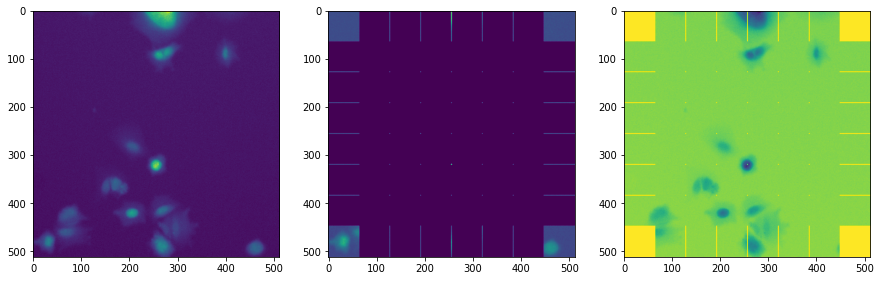

In [202]:
diff = untiled_image-tiled

fig, ax = plt.subplots(1, 3, figsize=(15, 12))
ax[0].imshow(tiled[0, ..., 0])
ax[1].imshow(untiled_image[0, ..., 0])#, cmap='jet')
ax[2].imshow(diff[0, ..., 0])
plt.show()

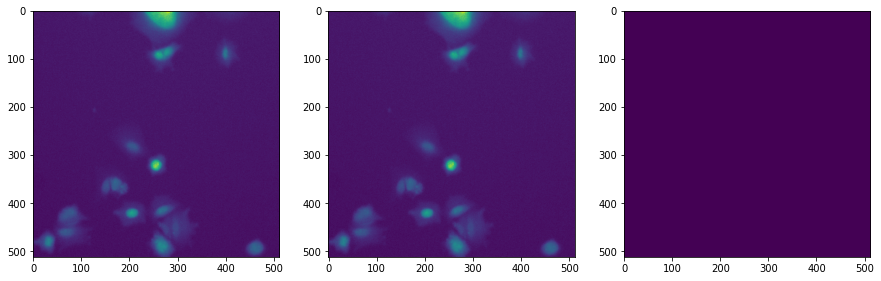

In [186]:
diff = untiled_image-tiled

fig, ax = plt.subplots(1, 3, figsize=(15, 12))
ax[0].imshow(tiled[0, ..., 0])
ax[1].imshow(untiled_image[0, ..., 0])#, cmap='jet')
ax[2].imshow(diff[0, ..., 0])
plt.show()

In [164]:
xy = (0, 100, 260, 0)

print("Tiled x,y is: ", tiled[xy])
print("Untiled x,y is: ", untiled_image[xy])
print("Diff x,y is: ", diff[xy])

Tiled x,y is:  4.0
Untiled x,y is:  4.000977
Diff x,y is:  0.0009770393


In [167]:
print(diff.max())

0.0029315948


In [168]:
print(tiled.max())

15.0
